# pynucastro Usage Examples

This notebook illustrates some of the higher-level data structures in `pynucastro`.

In [1]:
import pynucastro as pyna

## Examining a single rate

There are several ways to load a single rate.  If you down load the specific rate file from the [JINA ReacLib website](https://reaclib.jinaweb.org/), then you can load the rate via {py:func}`load_rate <pynucastro.rates.load_rate>` and
just giving that file name, e.g.,

```
c13pg = pyna.load_rate("c13-pg-n14-nacr")
```

However, an easier way to do this is to pass in the shorthand name for the rate to a library.  

Here we'll read in the entire ReacLib library using {py:obj}`ReacLibLibrary <pynucastro.rates.library.ReacLibLibrary>`
and get the ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ rate.  The result will be a 
{py:obj}`ReacLibRate <pynucastro.rates.reaclib_rate.ReacLibRate>` object. 

There are a lot of methods in the base
{py:obj}`Rate <pynucastro.rates.rate.Rate>` class that allow you to explore this rate.

In [2]:
rl = pyna.ReacLibLibrary()
c13pg = rl.get_rate_by_name("c13(p,g)n14")

A `Rate` can display itself nicely

In [3]:
c13pg

C13 + p ⟶ N14 + 𝛾

### The original ReacLib source

we can easily see the original source from ReacLib

In [4]:
print(c13pg.original_source)

4
         p  c13  n14                       nacrn     7.55100e+00          
 1.851550e+01 0.000000e+00-1.372000e+01-4.500180e-01                      
 3.708230e+00-1.705450e+00-6.666670e-01                                   
4
         p  c13  n14                       nacrr     7.55100e+00          
 1.396370e+01-5.781470e+00 0.000000e+00-1.967030e-01                      
 1.421260e-01-2.389120e-02-1.500000e+00                                   
4
         p  c13  n14                       nacrr     7.55100e+00          
 1.518250e+01-1.355430e+01 0.000000e+00 0.000000e+00                      
 0.000000e+00 0.000000e+00-1.500000e+00                                   


This is a rate that consists of 3 sets, each of which has 7 coefficients in a form:

$$\lambda = \exp \left [ a_0 + \sum_{i=1}^5 a_i T_9^{(2i-5)/3} + a_6 \ln T_9 \right ]$$

### Reference for the rate

We can find the reference in the literature that provided the rate (if available)

In [5]:
c13pg.source

{'Label': 'nacr',
 'Author': 'Angulo C.',
 'Title': 'A compilation of charged-particle induced thermonuclear reaction rates',
 'Publisher': 'Nuclear Physics, A656, 3-183',
 'Year': '1999',
 'URL': 'https://reaclib.jinaweb.org/labels.php?action=viewLabel&label=nacr'}

### Evaluating the rate

Our rate is just temperature dependent portion of the rate, usually expressed as $N_A \langle \sigma v \rangle$.  We can
evaluate this for a given temperature (in K) easily using the {py:func}`eval <pynucastro.rates.reaclib_rate.ReacLibRate.eval>` method:

In [6]:
c13pg.eval(1.e9)

3883.4778216250666

### Nuclei involved

The nuclei involved are all {py:obj}`Nucleus <pynucastro.nucdata.nucleus.Nucleus>` objects.  They have a lot of member data that give the properties of the nuclus (like `Z` and `N` for the proton and neutron number).

In [7]:
print(c13pg.reactants)
print(c13pg.products)

[p, C13]
[N14]


In [8]:
r2 = c13pg.reactants[1]
r2

C13

In [9]:
print(r2.Z, r2.N)

6 7


### Temperature sensitivity

We can find the temperature sensitivity about some reference temperature.  This is the exponent when we write the rate as 

$$r = r_0 \left ( \frac{T}{T_0} \right )^\nu$$

For a `ReacLibRate`, we can estimate this given a reference temperature, $T_0$, using the {py:func}`get_rate_exponent <pynucastro.rates.reaclib_rate.ReacLibRate.get_rate_exponent>` method.

In [10]:
c13pg.get_rate_exponent(2.e7)

16.21089670710968

### Plot the rate's temperature dependence

A reaction rate has a complex temperature dependence that is defined in the reaclib files.  The {py:func}`plot <pynucastro.rates.reaclib_rate.ReacLibRate.plot>` method will plot this for us

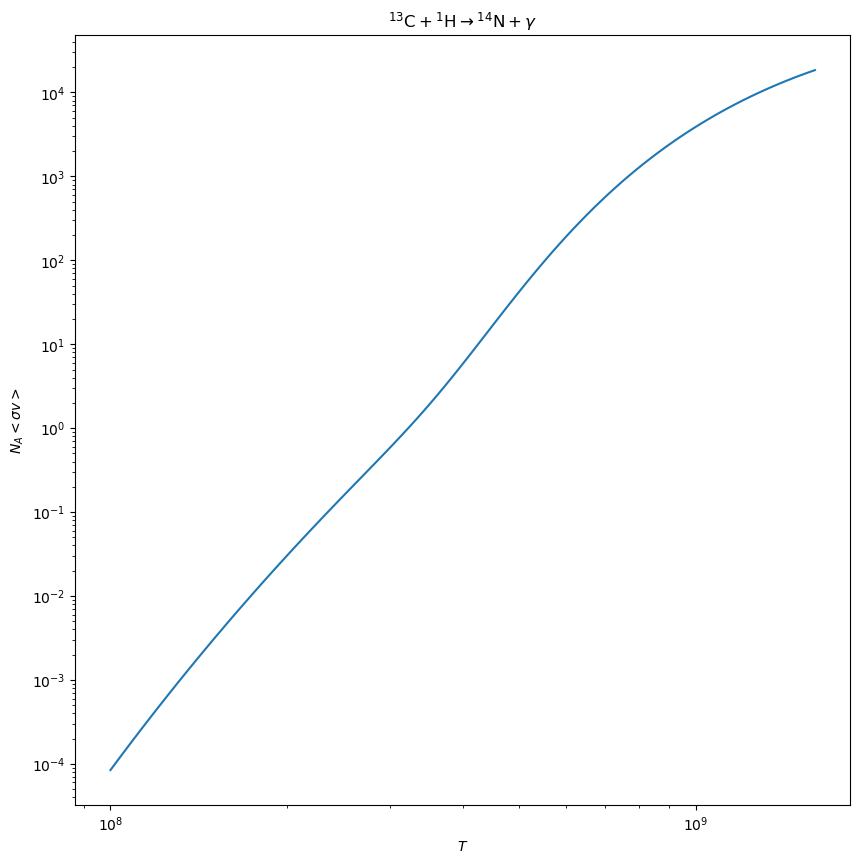

In [11]:
fig = c13pg.plot()

### Density dependence

A rate also knows its density dependence -- this is inferred from the reactants in the rate description and is used to construct the terms needed to write a reaction network as $dY/dt$, where $Y$ is the molar fraction.  

```{note}
Since we want reaction rates per gram, this number is one less than the number of nuclei.
```

In [12]:
c13pg.dens_exp

1

## Working with a group of rates

A {py:obj}`RateCollection <pynucastro.networks.rate_collection.RateCollection>` allows us to work with a group of rates.  This is used to explore their relationship.  Other classes (introduced soon) are built on this and will allow us to output network code directly.

Here we create a list with some of the individual rates in the ReacLib library

In [13]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]

rates = rl.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

Printing a rate collection shows all the rates

In [14]:
print(rc)

C12 + p ⟶ N13 + 𝛾
C13 + p ⟶ N14 + 𝛾
N13 ⟶ C13 + e⁺ + 𝜈
N13 + p ⟶ O14 + 𝛾
N14 + p ⟶ O15 + 𝛾
N15 + p ⟶ He4 + C12
O14 ⟶ N14 + e⁺ + 𝜈
O15 ⟶ N15 + e⁺ + 𝜈



The {py:func}`summary <pynucastro.networks.rate_collection.RateCollection.summary>` method gives some basic statistics about the network.

In [15]:
rc.summary()

Network summary
---------------
  explicitly carried nuclei: 9
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 8

  rates explicitly connecting nuclei: 8
  hidden rates: 0

  reaclib rates: 8
  weak tabular rates: 0
  temperature tabular rates: 0
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


More detailed information is provided by {py:func}`network_overview <pynucastro.networks.rate_collection.RateCollection.network_overview>`

In [16]:
print(rc.network_overview())

p
  consumed by:
     C12 + p ⟶ N13 + 𝛾
     C13 + p ⟶ N14 + 𝛾
     N13 + p ⟶ O14 + 𝛾
     N14 + p ⟶ O15 + 𝛾
     N15 + p ⟶ He4 + C12
  produced by:

He4
  consumed by:
  produced by:
     N15 + p ⟶ He4 + C12

C12
  consumed by:
     C12 + p ⟶ N13 + 𝛾
  produced by:
     N15 + p ⟶ He4 + C12

C13
  consumed by:
     C13 + p ⟶ N14 + 𝛾
  produced by:
     N13 ⟶ C13 + e⁺ + 𝜈

N13
  consumed by:
     N13 ⟶ C13 + e⁺ + 𝜈
     N13 + p ⟶ O14 + 𝛾
  produced by:
     C12 + p ⟶ N13 + 𝛾

N14
  consumed by:
     N14 + p ⟶ O15 + 𝛾
  produced by:
     C13 + p ⟶ N14 + 𝛾
     O14 ⟶ N14 + e⁺ + 𝜈

N15
  consumed by:
     N15 + p ⟶ He4 + C12
  produced by:
     O15 ⟶ N15 + e⁺ + 𝜈

O14
  consumed by:
     O14 ⟶ N14 + e⁺ + 𝜈
  produced by:
     N13 + p ⟶ O14 + 𝛾

O15
  consumed by:
     O15 ⟶ N15 + e⁺ + 𝜈
  produced by:
     N14 + p ⟶ O15 + 𝛾




### Show a network diagram

We visualize the network using {py:func}`plot <pynucastro.networks.rate_collection.RateCollection.plot>`, which leverages [NetworkX](https://networkx.org/).  

```{note}
By default, the network plot does not show H or He unless we have H + H or triple-$\alpha$ reactions in the network.  This is intended to reduce clutter.
```

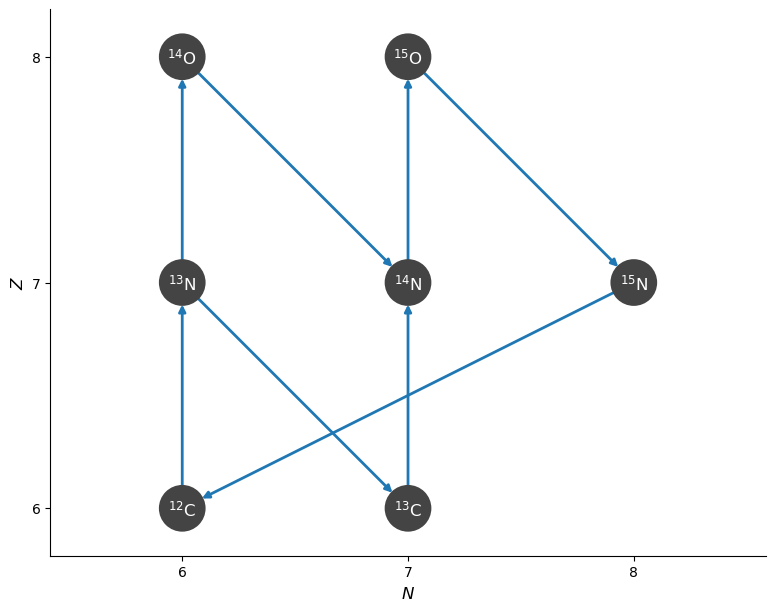

In [17]:
fig = rc.plot()

There are many options that can be used to configure this plot, for instance, creating a rotated version (useful for very large nets).

## Evaluate the rates

To evaluate the rates in a network, we need a composition, which is managed via a {py:obj}`Composition <pynucastro.networks.rate_collection.Composition>` object.

In [18]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

We can then pick a density and temperature and evaluate all of the rates in the network using {py:func}`evaluate_rates <pynucastro.networks.rate_collection.RateCollection.evaluate_rates>`.

In [19]:
rho = 1.e4
T = 1.e8
rc.evaluate_rates(rho, T, comp)

{C12 + p ⟶ N13 + 𝛾: 4.3825344233265836e-05,
 C13 + p ⟶ N14 + 𝛾: 0.00012943869407433363,
 N13 ⟶ C13 + e⁺ + 𝜈: 2.547501663259677e-07,
 N13 + p ⟶ O14 + 𝛾: 4.851762091044591e-06,
 N14 + p ⟶ O15 + 𝛾: 9.813707457231503e-07,
 N15 + p ⟶ He4 + C12: 0.0875185522576593,
 O14 ⟶ N14 + e⁺ + 𝜈: 2.003669148162566e-06,
 O15 ⟶ N15 + e⁺ + 𝜈: 1.0822012944765842e-06}

## Explore the network's rates

We can also interactively explore the rates in a notebook using Jupyter widgets.

```{tip}
You need to have `ipywidgets` installed for interactivity in Jupyter
```

Interactive exploration is enabled through the {py:obj}`Explorer <pynucastro.networks.rate_collection.Explorer>` class, which takes a `RateCollection` and a `Composition`

In [20]:
re = pyna.Explorer(rc, comp)
re.explore()

interactive(children=(FloatSlider(value=4.0, description='logrho', max=6.0, min=2.0), FloatSlider(value=8.0, d…